In [19]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from loess.Loess import Loess
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm
import seaborn as sns
import loess

In [21]:
# Defining Virus tramission temperarture range(in Fahrenheit)
a=60
b=95
# Converting Fahrenheit to Kelvin
a=(a-32)*5/9 + 273
b=(b-32)*5/9 + 273

In [22]:
wnv_file_path= "/Users/sparshagarwal/Downloads/WMV_data/Arbovirus_risk_modeling_US/WNV_human_cases/WNV_NI_NNI_1999to2015_prevalence_incidence_final_20180530.csv"
weather_data_path="/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/"

In [23]:
variable="air.2m_masked"
#variable="air.sfc_masked"
#variable="apcp_masked"
#variable="rhum.2m_masked"

In [24]:
variables= ["air.2m", "air.sfc", "apcp", "rhum.2m"]

In [25]:
months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years=range(1999, 2016)
summer_mon=["05", "06", "07", "08", "09"]   #Summer months for WNV transmission
months_desc={"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05": "May", "06": "Jun", "07" :"Jul", "08": "Aug", "09": "Sep", "10": "Oct", "11" : "Nov", "12" : "Dec" }

In [26]:
# Defining socio-economic zones/regions
socio_regions={"WA":1, "OR":1, "CA":1, "MT":2, "ID":2, "WY":2, "NV":2, "UT":2, "CO":2, "AZ":2, "NM":2,"ND":3, "SD":3, "MN":3, "NE":3, "IA":3,"KS":3, "MO":3, "OK":4 , "TX":4, "AR":4, "LA":4, "WI":5, "MI":5, "IL":5, "IN":5, "OH":5, "KY":6, "TN":6, "AL":6, "MS":6, "WV":7, "VA":7, "NC":7, "SC":7, "DC":7, "MD":7, "DE":7, "GA":7, "FL":7, "PA":8, "NJ":8, "NY":8, "MA":9, "CT":9, "NH":9, "VT":9, "ME":9, "RI":9}
socio_key={1:"Pacific", 2:"Mountain", 3:"West North Central", 4: "West South Central", 5: "East North Central", 6: "East South Central", 7: "South Atlantic", 8: "Middle Atlantic", 9: "New England"}

In [27]:
# Defining climatic zones/regions
weather_regions={"WA":1, "OR":1, "ID":1, "NV":2, "CA":2, "MT":3, "WY":3,"ND":3, "SD":3, "NE":3,"UT":4, "CO":4, "AZ":4, "NM":4, "MN":5,"WI":5, "MI":5, "IA":5,"KS":6, "OK":6 , "TX":6, "AR":6, "LA":6, "MS":6, "MO":7 , "IL":7, "IN":7, "OH":7, "KY":7, "TN":7, "WV":7, "AL":8, "VA":8, "NC":8, "SC":8, "GA":8, "FL":8, "DE":9, "DC":9, "MD":9, "PA":9, "NJ":9, "NY":9, "MA":9, "CT":9, "NH":9, "VT":9, "ME":9, "RI":9}
weather_key={1: "Northwest", 2: "West", 3: "West North Central", 4: "Southwest", 5: "East North Central", 6: "South", 7: "Central", 8: "Southeast", 9:"Northeast"}

In [28]:
# socio_zone={1: "Pacific", 2: "Mountain", 3: "West North Central", 4: "West South Central", 5: "East North Central", 6: "East South Central", 7: "South Atlantic", 8: "Middle Atlantic", 9: "New England"}
# weather_zone={1: "Northwest", 2: "West", 3: "West North Central", 4: "SouthWest", 5: "Upper Midwest", 6: "South", 7: "Ohio Valley", 8: "Southeast", 9: "Northeast"}
# temp=pd.DataFrame()
# temp["Code"]= socio_zone.keys()
# temp["Zone"]= socio_zone.values()

In [29]:
#Importing WNV yearly data
df= pd.read_csv(wnv_file_path, encoding='latin-1')
df=df[df["Select_County"]==1]
df.rename(columns = {'GEOID10':'GEOID'}, inplace = True)
df=df[df["STNAME"]!="California"]

In [30]:
# Adding a column for incident year
incident_year=[years[-1] for i in range(len(df))]
for j in range(len(df)):
    for i in years:
        if(df.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df["Incident_year"]=incident_year

In [31]:
# Adding temp, precp, and humidity data
df_mod=df.copy()
for i in variables:
    for j in years:
        for k in range(len(months)):
            #Importing monthly Variable data
            data= pd.read_csv(weather_data_path + i +"_masked/"+ str(j) + "_" + months[k] + "_masked.csv")
            data=data[["GEOID", "mean"]]
            data.rename(columns = {'mean': i + '_' + str(j) + "_" + months[k]}, inplace = True)
            df_mod=df_mod.join(data.set_index('GEOID'), on='GEOID')

In [32]:
#Adding socioeconomic and weather regions classification column
sc=[]
we=[]
for i in range(len(df_mod)):
    sc.append(socio_regions[df_mod.iloc[i]["STUSPS"]])
    we.append(weather_regions[df_mod.iloc[i]["STUSPS"]])
df_mod["Socio_econ_class"]=sc 
df_mod["Weather_class"]=we

In [33]:
# #Calculating average of mean summer temperature, precipitaion, humidity,  for every county and storing 
# #all the corresponding attributes in different lists so that a simplified dataframe can be made.
##Months considered are May-Sept.
# geo_id=[]
# mean_temp_2m=[]
# mean_temp_sfc=[]
# mean_prec=[]
# mean_hum=[]
# mean_ir=[]
# w_cl=[]
# s_cl=[]
# for i in range(len(df_mod)):
#     summer_temp_2m=[]
#     summer_temp_sfc=[]    
#     summer_prec=[]
#     summer_hum=[]
#     summer_ir=[]
#     inc_year= df_mod.iloc[i]["Incident_year"]  # 1st year of WNV incidence
                                     
#     for j in range(inc_year+1, years[-1]+1):
#         avg_temp_2m=[]
#         avg_temp_sfc=[]    
#         avg_prec=[]
#         avg_hum=[]
#         for k in summer_mon:
#             #Storing summer temp/prec/hum values for a certain year.
#             avg_temp_2m.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k] -273)
#             avg_temp_sfc.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k] -273)
#             avg_prec.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
#             avg_hum.append(df_mod.iloc[i][variables[3] + "_" + str(j) + "_" + k])
#         #Calculating and storing the average summer temp/prec/hum value for a certain year.
#         summer_temp_2m.append(np.mean(avg_temp_2m))    
#         summer_temp_sfc.append(np.mean(avg_temp_sfc))
#         summer_prec.append(np.mean(avg_prec))
#         summer_hum.append(np.mean(avg_hum))
#         summer_ir.append(df_mod.iloc[i]["NI_IR_" + str(j)])
                                   
#     if(inc_year!=years[-1]):
#         # Calculating mean of varaibles across all the years
#         mean_temp_2m.append(np.mean(summer_temp_2m))
#         mean_temp_sfc.append(np.mean(summer_temp_sfc))
#         mean_prec.append(np.mean(summer_prec))
#         mean_hum.append(np.mean(summer_hum))
#         mean_ir.append(np.mean(summer_ir))
#         geo_id.append(df_mod.iloc[i]["GEOID"])
#         w_cl.append(df_mod.iloc[i]["Weather_class"])
#         s_cl.append(df_mod.iloc[i]["Socio_econ_class"])
        

In [320]:
#Calculating average of mean summer temperature, precipitaion, humidity,  for every county and storing 
#all the corresponding attributes in different lists so that a simplified dataframe can be made.
#Months considered with temperature lying in CDD_temp range, not just May-Sept.
geo_id=[]
mean_temp_2m=[]
mean_temp_sfc=[]
mean_prec=[]
mean_hum=[]
mean_ir=[]
w_cl=[]
s_cl=[]
for i in range(len(df_mod)):
    summer_temp_2m=[]
    summer_temp_sfc=[]    
    summer_prec=[]
    summer_hum=[]
    summer_ir=[]
    inc_year= df_mod.iloc[i]["Incident_year"]  # 1st year of WNV incidence
                                     
    for j in range(inc_year+1, years[-1]+1):
        cdd_mon=[]
        for k in months:
            if(df_mod.iloc[i][variables[0]+ "_" + str(j) + "_" + k]>=a and df_mod.iloc[i][variables[0]+ "_" + str(j) + "_" + k]<=b):
                cdd_mon.append(k)

        avg_temp_2m=[]
        avg_temp_sfc=[]    
        avg_prec=[]
        avg_hum=[]
        for k in cdd_mon:
            #Storing summer temp/prec/hum values for a certain year.
            avg_temp_2m.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k] -273)
            avg_temp_sfc.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k] -273)
            avg_prec.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
            avg_hum.append(df_mod.iloc[i][variables[3] + "_" + str(j) + "_" + k])
        #Calculating and storing the average summer temp/prec/hum value for a certain year.
        summer_temp_2m.append(np.mean(avg_temp_2m))    
        summer_temp_sfc.append(np.mean(avg_temp_sfc))
        summer_prec.append(np.mean(avg_prec))
        summer_hum.append(np.mean(avg_hum))
        summer_ir.append(df_mod.iloc[i]["NI_IR_" + str(j)])
                                   
    if(inc_year!=years[-1]):
        # Calculating mean of varaibles across all the years
        mean_temp_2m.append(np.mean(summer_temp_2m))
        mean_temp_sfc.append(np.mean(summer_temp_sfc))
        mean_prec.append(np.mean(summer_prec))
        mean_hum.append(np.mean(summer_hum))
        mean_ir.append(np.mean(summer_ir))
        geo_id.append(df_mod.iloc[i]["GEOID"])
        w_cl.append(df_mod.iloc[i]["Weather_class"])
        s_cl.append(df_mod.iloc[i]["Socio_econ_class"])
        

In [321]:
#For average across all the years
df_combined=pd.DataFrame()
df_combined["GEOID"]=geo_id
df_combined["IR"]=mean_ir
df_combined["Temp_2m"]=mean_temp_2m
df_combined["Temp_sfc"]=mean_temp_sfc
df_combined["Prec"]=mean_prec
df_combined["Hum"]=mean_hum
df_combined["Weather_class"]=w_cl
df_combined["Socio_econ_class"]=s_cl

In [323]:
#For every individual year (To use this, first run the code after the the code for plotting the graphs)
df_combined=pd.DataFrame()
df_combined["GEOID"]=geo_id_1
df_combined["IR"]=ir
df_combined["Temp_2m"]=temp_2m
df_combined["Temp_sfc"]=temp_sfc
df_combined["Prec"]=prec
df_combined["Hum"]=hum
df_combined["Weather_class"]=w_cl_1
df_combined["Socio_econ_class"]=s_cl_1

In [324]:
# #To export data
# df_combined.to_csv(r'/Users/sparshagarwal/Desktop/Dataframe.csv')

In [305]:
#df_combined=df_combined[df_combined["Weather_class"]==9]
#df_combined=df_combined[df_combined["Socio_econ_class"]==9]

In [306]:
#Variable for which the trend has to be plotted
var='Temp_2m'
#var='Temp_sfc'
#var='Prec'
#var='Hum'

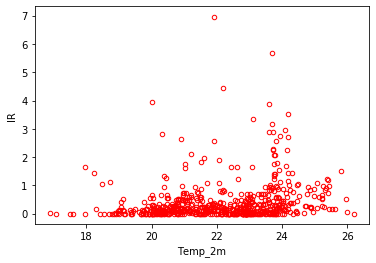

In [307]:
df_combined.plot(kind='scatter',x=var,y='IR',color="None", edgecolors='red')

In [308]:
#Creating bins
if(var=="Temp_2m"):
    bin_size=0.05
    start=10   #Starting value for binning
    stop=35    #Ending value for binning
    bins=list(range(start*100,stop*100,int(bin_size*100)))
    bins=[i/100 for i in bins]
elif(var=="Prec"):
    bin_size=0.05
    start=0
    stop=6
    bins=list(range(start*100,stop*100,int(bin_size*100)))
    bins=[i/100 for i in bins]
elif(var=="Hum"):
    bin_size=1
    start=0
    stop=100
    bins=list(range(start*100,stop*100,int(bin_size*100)))
    bins=[i/100 for i in bins]

In [309]:
df_bin=df_combined[df_combined["IR"]!=0]   # Removing entries with IR=0 
df_bin=df_bin[["IR", var]]
df_bin["bin"]=pd.cut(x=df_bin[var], bins=bins)
df_bin=df_bin.sort_values(by=var).copy()
df_bin_count=df_bin.sort_values(by=var).copy()   #df_bin_count is used for weighting the data.
df_bin=df_bin.groupby("bin").mean()
df_bin_count=df_bin_count.groupby("bin").count()
df_bin=df_bin[df_bin["IR"]>0]
df_bin_count=df_bin_count[df_bin_count["IR"]>0]

In [310]:
#For storing repetitive rows as a way of weighting points
IR_temp=[]
Var_temp=[]

In [311]:
for i in range(len(df_bin)):
    for j in range(df_bin_count.iloc[i]["IR"]):
        IR_temp.append(df_bin.iloc[i]["IR"])
        Var_temp.append(df_bin.iloc[i][var])

In [312]:
# #Making new datatframe having repetitive points in every bin
# df_bin=pd.DataFrame()
# df_bin["IR"]=IR_temp
# df_bin[var]=Var_temp

In [313]:
df_bin

IR    Temp_2m
bin                               
(16.85, 16.9]  0.035131  16.886241
(17.05, 17.1]  0.006872  17.067629
(17.95, 18.0]  1.648018  17.955697
(18.2, 18.25]  1.439605  18.221645
(18.25, 18.3]  0.164066  18.284435
...                 ...        ...
(25.4, 25.45]  0.766660  25.424134
(25.5, 25.55]  0.162682  25.524832
(25.6, 25.65]  0.165925  25.638383
(25.8, 25.85]  1.499318  25.808726
(25.95, 26.0]  0.289792  25.973088

[127 rows x 2 columns]

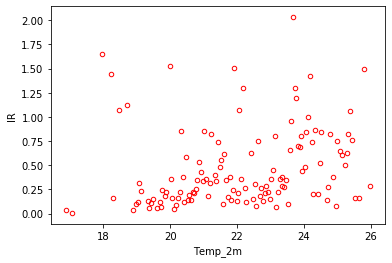

In [314]:
df_bin.plot(kind='scatter',x=var,y='IR',color="None", edgecolors='red')

In [315]:
#LOWESS smoothing

In [316]:
"""
Local Regression (LOESS) estimation routine. No need to read through the function.
"""
import numpy as np
import pandas as pd
import scipy


def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)



def loess(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

In [317]:
#Implementing LOESS smoothing
xvals=list(df_bin[var])
yvals=list(df_bin["IR"])
regsDF, evalDF = loess(xvals, yvals, alpha=0.4, poly_degree=1)  # Value of alpha can be varied for varying smoothness.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:117: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



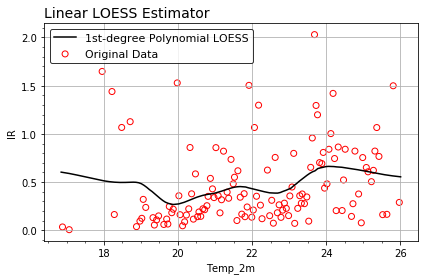

In [318]:
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values

# Generate x-y scatterplot with loess estimate overlaid.
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.minorticks_on()
#plt.xlabel('hi')
ax1.scatter(xvals, yvals, label="Original Data",color="None", edgecolors='red')
ax1.plot(l_x, l_y, color='black', label="1st-degree Polynomial LOESS")
ax1.set_title("Linear LOESS Estimator", loc="left", fontsize=14)
ax1.legend(loc="upper left",
           scatterpoints=1,
           fontsize=11,
           frameon=True,
           fancybox=True,
           facecolor="#FFFFFF",
           edgecolor="#000000")
ax1.set_xlabel(var)
ax1.set_ylabel("IR")
plt.tight_layout()
plt.show()

In [ ]:
#The code below is for all the years separately, plotting IR vs average summer value of the variable.

In [ ]:
###Months considered are May-Sept.
# geo_id_1=[]
# temp_2m=[]
# temp_sfc=[]
# prec=[]
# hum=[]
# ir=[]
# w_cl_1=[]
# s_cl_1=[]
# for i in range(len(df_mod)):
#     inc_year= df_mod.iloc[i]["Incident_year"]  # 1st year of WNV incidence
                                     
#     for j in range(inc_year+1, years[-1]+1):
#         avg_temp_2m=[]
#         avg_temp_sfc=[]    
#         avg_prec=[]
#         avg_hum=[]
#         for k in summer_mon:
#             avg_temp_2m.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k] -273)
#             avg_temp_sfc.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k] -273)
#             avg_prec.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
#             avg_hum.append(df_mod.iloc[i][variables[3] + "_" + str(j) + "_" + k])
#         temp_2m.append(np.mean(avg_temp_2m))    
#         temp_sfc.append(np.mean(avg_temp_sfc))
#         prec.append(np.mean(avg_prec))
#         hum.append(np.mean(avg_hum))
#         ir.append(df_mod.iloc[i]["NI_IR_" + str(j)])
#         geo_id_1.append(df_mod.iloc[i]["GEOID"])
#         w_cl_1.append(df_mod.iloc[i]["Weather_class"])
#         s_cl_1.append(df_mod.iloc[i]["Socio_econ_class"])

In [237]:
#Months considered with temperature lying in CDD_temp range, not just May-Sept.
geo_id_1=[]
temp_2m=[]
temp_sfc=[]
prec=[]
hum=[]
ir=[]
w_cl_1=[]
s_cl_1=[]
for i in range(len(df_mod)):
    inc_year= df_mod.iloc[i]["Incident_year"]  # 1st year of WNV incidence
                                     
    for j in range(inc_year+1, years[-1]+1):
        cdd_mon=[]
        for k in months:
            if(df_mod.iloc[i][variables[0]+ "_" + str(j) + "_" + k]>=a and df_mod.iloc[i][variables[0]+ "_" + str(j) + "_" + k]<=b):
                cdd_mon.append(k)
        avg_temp_2m=[]
        avg_temp_sfc=[]    
        avg_prec=[]
        avg_hum=[]
        for k in cdd_mon:
            avg_temp_2m.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k] -273)
            avg_temp_sfc.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k] -273)
            avg_prec.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
            avg_hum.append(df_mod.iloc[i][variables[3] + "_" + str(j) + "_" + k])
        temp_2m.append(np.mean(avg_temp_2m))    
        temp_sfc.append(np.mean(avg_temp_sfc))
        prec.append(np.mean(avg_prec))
        hum.append(np.mean(avg_hum))
        ir.append(df_mod.iloc[i]["NI_IR_" + str(j)])
        geo_id_1.append(df_mod.iloc[i]["GEOID"])
        w_cl_1.append(df_mod.iloc[i]["Weather_class"])
        s_cl_1.append(df_mod.iloc[i]["Socio_econ_class"])

In [ ]:
#Now go to previous cells where data frame (df_combined) is made

In [ ]:
# The code below is for monthly temperatures/precipitation /humidity, with one point per county. 

In [ ]:
for k in range(len(months)):
    df_mod=df.copy()
    for j in years:
        temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/" + variable +"/"+ str(j) + "_" + months[k] + "_masked.csv")
        temp=temp[["GEOID", "mean"]]
        temp.rename(columns = {'mean':'mean_' + str(j)}, inplace = True)
        df_mod=df_mod.join(temp.set_index('GEOID'), on='GEOID')
            
    x=[]
    y=[]
    for j in range(len(df_mod)):
        a=[]
        b=[]
        for i in years:  
            if(df_mod.iloc[j]["NI_IR_" + str(i)]!=0):
                for l in range(i+1, 2016):
                    a.append(df_mod.iloc[j]["NI_IR_" + str(l)])
                    if((variable=="air.2m_masked") or (variable=="air.sfc_masked")):
                        b.append(df_mod.iloc[j]["mean_" + str(l)]-273)
                    else:
                        b.append(df_mod.iloc[j]["mean_" + str(l)]) 
                if(i!=2015):
                    x.append(sum(b)/len(b))
                    y.append(sum(a)/len(a))
                break
        
    df_combined=pd.DataFrame()
    df_combined["Mean"]=x
    df_combined["IR"]=y
    ax=plt.subplot(4,3,k+1)
    ax.set_title(months_desc[str(months[k])])
    df_combined.plot(kind='scatter',x='Mean',y='IR', ax=ax, figsize=(25,25), color="None", edgecolors='red') 